# Compare VQPE, UVQPE, and QCELS 

In [1]:
from __future__ import division
import sys,math,random,numpy as np,numpy.typing as npt,scipy,itertools,tqdm,warnings,matplotlib.pylab as pl
from numpy import linalg as LA, inf
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from matplotlib import pyplot as plt, cm as cm, mlab as ml, rc
from matplotlib.colors import LinearSegmentedColormap, LogNorm, Normalize
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from scipy.linalg import svd,eig,eigh,toeplitz,circulant,lstsq
from scipy.io import savemat, loadmat
from ipynb.fs.full.VQPE_utilities import S_gen,H_gen,VQPE_dmd,UVQPE_dmd
from ipynb.fs.full.QCELS_utilities import fit_data, QCELS_gse

###### Relevant VQPE, UVQPE, QCELS routines are imported from VQPE_utilities and QCELS_utilities ######
def wrap(dat):
    """
    Combine the real and imaginary parts into a single complex-valued array.

    Parameters:
    - dat: Real and imaginary parts of complex data
    
    Returns:
    - 1d array of complex data
    """
    return dat[0] + 1j*dat[1]

def scale(E):
    """
    Scale the Hamiltonian spectrum.

    Parameters:
    - E: Energy spectrum of Hamiltonian (E_0, E_1, ..., E_{Hilbert space dimension})
    
    Returns:
    - Scaled energy spectrum in [-a, a] for a = π/4
    """
    E_center = E - (E.min()+E.max())/2
    return np.pi*E_center / (4*np.abs(E_center).max())

def state(gs_overlap, E):
    """
    Generate a reference state with prescribed ground state overlap.

    Parameters:
    - gs_overlap: prescribed value of ground state overlap in the reference state (0 <=1 gs_overlap <= 1)
    - E: Energy spectrum of Hamiltonian
    
    Returns:
    - state: reference state with specified overlap on the ground state 
             and uniform overlap over the remaining eigenstates
    """
    state = np.zeros(len(E), dtype=complex)
    state[0] = np.sqrt(gs_overlap)
    state[1:] = np.sqrt((1-gs_overlap)/(len(E)-1)) 
    return state

def plot(result, gs_overlap, eps, r_SVD, molecule):
    """
    Plot the estimated ground state energy from VQPE, UVQPE, and QCELS.

    Parameters:
    - result: LiH_result[0] <-> VQPE energy error evaluated over the time grid  
              LiH_result[1] <-> UVQPE energy error evaluated over the time grid 
              LiH_result[2] <-> QCELS energy error evaluated over the time grid
              where we keep track of 250 time steps in total
    - gs_overlap: prescribed value of ground state overlap in the reference state
    - eps: Standard deviation of gaussian noises on matrix elements
    - r_SVD: Relative threshold value for SVD thresholding
    - molecule: molecule of choice 
    
    """
    xvals = np.arange(0, 251-1, 2)
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    ax.plot(4*xvals, result[0][xvals], 'gx', mfc='none', mew=1.75,
            label=r'VQPE $\left( \tilde{\delta}_{\rm VQPE} = %g \right)$' % r_SVD)
    ax.plot(2*xvals, result[1][xvals], 'bx', mfc='none', mew=1.75,
            label=r'UVQPE $\left( \tilde{\delta}_{\rm UVQPE} = %g \right)$' % r_SVD)                
    ax.plot(2*(xvals+1), result[2][xvals], 'kx', mfc='none', mew=1.75, label=r'QCELS ($k=1$)') 
    ax.axhspan(1E-12, 1E-3, color='pink', alpha=0.15)

    ax.set_yscale('log')
    if eps == 0:
        ax.set_ylim([1E-12, 1E-0])
    else:
        ax.set_ylim([1E-6, 1E-0])
    ax.set_ylabel(r'Absolute Error', fontsize=22)
    ax.set_xlim([0, 500]), ax.set_xticks(np.arange(0, 500+1, 100))
    ax.set_xlabel(r'# Overlap Measurements', fontsize=20)
    ax.set_title(r'%s (Noise $\epsilon=%g$, $|\langle 0|\phi_0 \rangle|^2$=%g)' % 
                 (molecule, eps, gs_overlap), fontsize=20, pad=10)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(loc="best", edgecolor='none', fontsize=12.5, borderpad=0)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["mathtext.fontset"] = "cm"
    return

def plot_tsteps(result, gs_overlap, eps, r_SVD, molecule):
    
    xvals = np.arange(0, 251-1, 2)
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4))
    ax.plot(xvals, result[0][xvals], 'gx', mfc='none', mew=1.75,
            label=r'VQPE $\left( \tilde{\delta}_{\rm VQPE} = %g \right)$' % r_SVD)
    ax.plot(xvals, result[1][xvals], 'bx', mfc='none', mew=1.75,
            label=r'UVQPE $\left( \tilde{\delta}_{\rm UVQPE} = %g \right)$' % r_SVD)                
    ax.plot(xvals+1, result[3][xvals], 'kx', mfc='none', mew=1.75, label=r'QCELS ($k=1$)') 
    ax.axhspan(1E-12, 1E-3, color='pink', alpha=0.15)
    
    ax.set_yscale('log')
    if eps == 0:
        ax.set_ylim([1E-12, 1E-0])
    else:
        ax.set_ylim([1E-6, 1E-0])
    ax.set_ylabel(r'Absolute Error', fontsize=22)
    ax.set_xlim([0, 250]), ax.set_xticks(np.arange(0, 250+1, 50))
    ax.set_xlabel(r'# Overlap Measurements', fontsize=20)
    ax.set_title(r'%s (Noise $\epsilon=%g$, $|\langle 0|\phi_0 \rangle|^2$=%g)' % 
                 (molecule, eps, gs_overlap), fontsize=20, pad=10)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.legend(loc="best", edgecolor='none', fontsize=12.5, borderpad=0)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["mathtext.fontset"] = "cm"
    return

# ====== Read in Cr2 Hamiltonian eigenvalues and HF overlaps with eigenvectors ======
f = open('cr2_4000','r')
E_Cr2, HF = np.zeros(4000), np.zeros(4000)        
for i in range(4000+1):
    line = f.readline()
    if i > 0:
        arr = line.split(' ')
        E_Cr2[i-1], HF[i-1] = float(arr[0]), float(arr[1])
        
# ====== Read in H6 and LiH Hamiltonian eigenvalues ======
E_H6 = loadmat('E_H6.mat')['eigs_H6'][0]        
E_LiH = loadmat('E_LiH.mat')['eigs_LiH'][0]    
        
# ====== Scale spectra ======
Es_Cr2 = scale(E_Cr2)
Es_H6 = scale(E_H6)
Es_LiH = scale(E_LiH)

# ====== Set noise and SVD thresholding parameters ======
eps = 1E-2                           # noise level
s_SVD = 1E-2                         # singular value cutoff of overlap matrix
if eps == 0:
    r_SVD = 1E-12                    # relative singular value cutoff of overlap matrix (set to <=0 to turn off)
else:
    r_SVD = 10*eps
eigindx = 0                          # approximated energy level (eig=0 -> ground state energy)

# ====== Generate linear time grid ======
# NT_max: total number of time steps
# tau: unit timestep 
# t0: initial time step
NT_max, tau, t0 = 651, 1, 1
time_grid = tau*np.arange(NT_max) 
J1 = 251
J2 = 251+1  

# ====== Set prescribed ground state overlap ======
gs_overlap = 0.05

print('tau: %g' % tau)
print('eps: %g' % eps)
print('overlap: %g' % gs_overlap)

R2: 0.975498
RMSE: 0.068908
R2: 0.985383
RMSE: 0.0695406
tau: 1
eps: 0.01
overlap: 0.05


# LiH

In [2]:
print('LiH')
# ====== Generate reference state with prescribed ground state overlap ======
ref = state(gs_overlap, Es_LiH)

# ====== Generate Hamiltonian and overlap matrix elements (imported from VQPE_utilities) ======
# S_LiH: <Φ|exp(-iHkdt)|Φ>
# H_LiH: <Φ|H exp(-iHkdt)|Φ>
S_LiH = S_gen(ref, time_grid, Es_LiH, eps)
H_LiH = H_gen(ref, time_grid, Es_LiH, eps)

# ====== Run VQPE (imported from VQPE_utilities) ======
vqpe = VQPE_dmd(ref, time_grid[:J1], wrap(S_LiH)[:J1], wrap(H_LiH)[:J1], Es_LiH, s_SVD, r_SVD, eigindx)

# ====== Run UVQPE (imported from VQPE_utilities) ======
uvqpe = UVQPE_dmd(ref, J1, time_grid[1], wrap(S_LiH), Es_LiH, s_SVD, r_SVD, eigindx)

# ====== Run QCELS (imported from QCELS_utilities) ======
init_bounds = np.array([-1, 0])
qcels_LiH = QCELS_gse(wrap(S_LiH)[t0:J2], time_grid[t0:J2], Es_LiH, init_bounds)

LiH


## Plot estimated ground state energy of LiH

eps: 0.01 overlap: 0.05


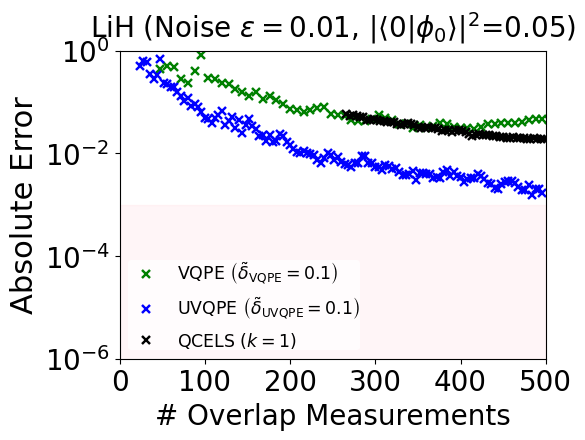

In [3]:
# ====== Plot VQPE, UVQPE, and QCELS results ======
# sf_LiH: rescaling factor for final energy conversion (since we started by rescaling the Hamiltonian spectrum)
sf_LiH = np.pi/(2*(E_LiH[-1]-E_LiH[0]))

# LiH_result: energy errros before rescaling where
#             LiH_result[0] <-> VQPE, LiH_result[1] <-> UVQPE, LiH_result[2] <-> QCELS
LiH_result = np.zeros((3, J1))
LiH_result[0] = vqpe[0] - Es_LiH[0]
LiH_result[1] = uvqpe[0] - Es_LiH[0]
LiH_result[3] = qcels_LiH.flatten()
LiH_result =  np.abs(LiH_result)/sf_LiH
print('eps:',eps,'overlap:',gs_overlap)
plot(LiH_result, gs_overlap, eps, r_SVD, 'LiH')

# LiH (Fig.6 Left, Middle, and Right)

In [ ]:
print('Cr2')

# ====== Generate reference state with prescribed ground state overlap ======
ref = state(gs_overlap, Es_Cr2)
print('eps: %g' % eps)
print('overlap: %g' % gs_overlap)

# ====== Load Hartree-Fock reference state ======
# ref = HF
# gs_overlap_HF = np.abs(HF[0])**2

# ====== Load Hamiltonian and overlap matrix elements ======
# S_Cr2: <Φ|exp(-iHkdt)|Φ>
# H_Cr2: <Φ|H exp(-iHkdt)|Φ>
# use 'S_Fig2l.mat', 'S_Fig2m.mat', or 'S_Fig2r.mat' for generating left, middle, and right panels of Fig.6
# use 'H_Fig2l.mat', 'H_Fig2m.mat', or 'H_Fig2r.mat' for generating left, middle, and right panels of Fig.6

S_Cr2 = loadmat('S_Fig2m.mat')['dataS'].flatten()
H_Cr2 = loadmat('H_Fig2m.mat')['dataH'].flatten()

# ====== Run VQPE (imported from VQPE_utilities) ======
vqpe = VQPE_dmd(ref, time_grid[:J1], S_Cr2[:J1], H_Cr2[:J1], Es_Cr2, s_SVD, r_SVD, eigindx)

# ====== Run UVQPE (imported from VQPE_utilities) ======
uvqpe = UVQPE_dmd(ref, J1, time_grid[1], S_Cr2, Es_Cr2, s_SVD, r_SVD, eigindx)

# ====== Run QCELS (imported from QCELS_utilities) ======
init_bounds = np.array([-1, 0])
qcels_Cr2 = QCELS_gse(S_Cr2[t0:J2], time_grid[t0:J2], Es_Cr2, init_bounds)

## Plot estimated ground state energy of Cr2

In [ ]:
# ====== Plot VQPE, UVQPE, and QCELS results ======
# sf_Cr2: rescaling factor for final energy conversion (since we started by rescaling the Hamiltonian spectrum)
sf_Cr2 = np.pi/(2*(E_Cr2[-1]-E_Cr2[0]))

# Cr2_result: energy errros before rescaling where
#             Cr2_result[0] <-> VQPE, Cr2_result[1] <-> UVQPE, Cr2_result[2] <-> QCELS
Cr2_result = np.zeros((3, J1))
Cr2_result[0] = vqpe[0] - Es_Cr2[0]
Cr2_result[1] = uvqpe[0] - Es_Cr2[0]
Cr2_result[2] = qcels_Cr2.flatten()
Cr2_result =  np.abs(Cr2_result)/sf_Cr2

print('eps:',eps,'overlap:',gs_overlap)
plot_tsteps(Cr2_result, gs_overlap, eps, r_SVD, 'Cr2')

In [ ]:
###### save data for calculations run with arbitrary initial state ######
# np.savetxt('vqpeCr2_o%g_eps%g.dat' % (gs_overlap, eps), np.c_[4*np.arange(J1),Cr2_result[0]])
# np.savetxt('uvqpeCr2_o%g_eps%g.dat' % (gs_overlap, eps), np.c_[2*np.arange(J1),Cr2_result[1]])
# np.savetxt('qcelsCr2_o%g_eps%g.dat' % (gs_overlap, eps), np.c_[2*np.arange(1,J1+1),Cr2_result[2]])

###### save data for calculations run with HF initial state ######
# np.savetxt('vqpeCr2_HF_eps%g.dat' % eps, np.c_[4*np.arange(J1),Cr2_result[0]])
# np.savetxt('uvqpeCr2_HF_eps%g.dat' % eps, np.c_[2*np.arange(J1),Cr2_result[1]])
# np.savetxt('qcelsCr2_HF_eps%g.dat' % eps, np.c_[2*np.arange(1,J1+1),Cr2_result[2]])